   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 48.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 15.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 4.25.7 which is incompatible.
google-cloud-bigtable 2.27.0 requires google-api-core[grpc]<3.0.0dev,>=2.16.0, but you have google-api-core 1.34.1 which is incompatible.
pandas-gbq 0.25.0 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
tensorflow-decision-forests 1.10.0 requires tens

<ipython-input-1-d57831428439>:334: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_checkpoint, map_location=device)


Processing video with enhancement and drowsiness detection (every 5th frame)...


Processing video frames: 100%|██████████| 38/38 [00:17<00:00,  2.15frame/s]


Video processing complete. Saved to: /kaggle/working/enhanced_output/enhanced_sampled_5_low low light open.mp4
Processed 38 frames out of 189 total frames (every 5th frame)
Average PSNR: 20.82 dB
Average SSIM: 0.1240


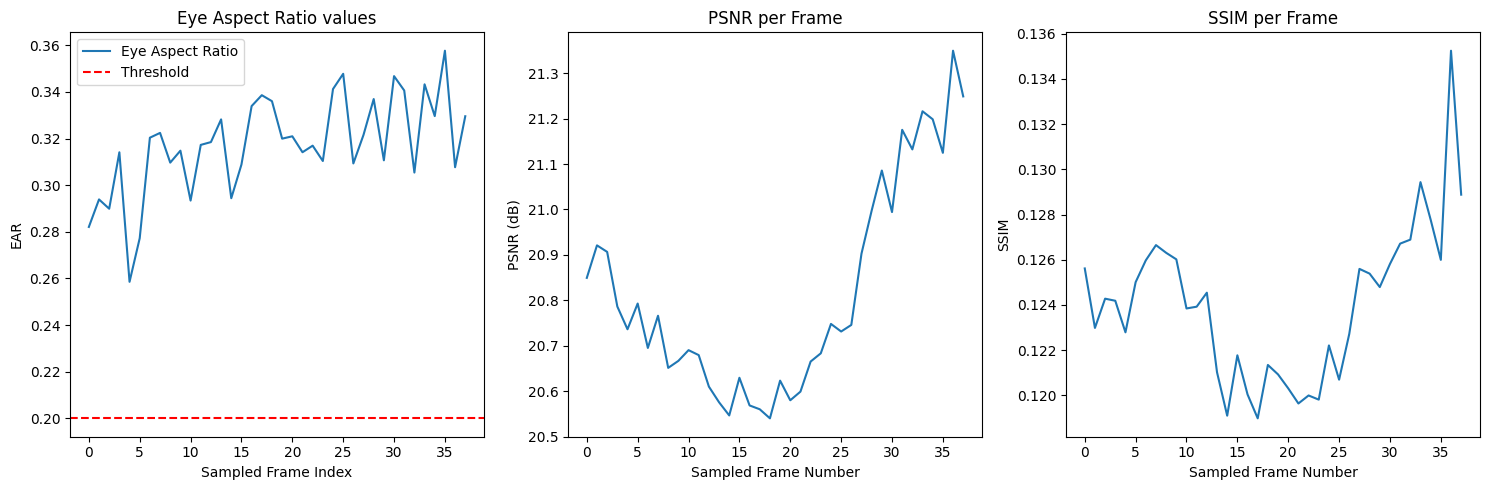

In [1]:
!pip install mediapipe
# Import necessary libraries
import os
import sys
import cv2
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import argparse
import mediapipe as mp
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
# Clear sys.argv so extra arguments from the kernel don't interfere with argparse
sys.argv = ['']

# -------------------------------------------------------------------
# Default Path Configurations for Kaggle
# -------------------------------------------------------------------
MODEL_PATH = "/kaggle/input/zerodidcefinalmodel/zero_didce_model.pth"  # Your model checkpoint path
INPUT_PATH = "/kaggle/input/driver-drowsiness-detection-low-light-videos/low low light open.mp4"     # Your input video file
OUTPUT_BASE_DIR = "/kaggle/working/enhanced_output"                    # Directory for enhanced outputs
os.makedirs(OUTPUT_BASE_DIR, exist_ok=True)

# -------------------------------------------------------------------
# Model Definition and Enhancement Function
# -------------------------------------------------------------------
class DiDCENet(nn.Module):
    def __init__(self):
        super(DiDCENet, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.dropout = nn.Dropout(0.5)
        self.skip_conv = nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)
    def forward(self, x):
        x1 = self.relu(self.conv1(x))
        x2 = self.relu(self.conv2(x1))
        x3 = self.relu(self.conv3(x2))
        # Process inverted input
        inverted_x = 1 - x
        x11 = self.relu(self.conv1(inverted_x))
        x21 = self.relu(self.conv2(x11))
        x31 = self.relu(self.conv3(x21))
        combined_features = torch.cat([x3, x31], dim=1)
        combined_features = self.dropout(combined_features)
        curve_map = torch.tanh(self.skip_conv(combined_features))
        return curve_map

def adaptive_light_enhancement(x_input, curve_map):
    alpha = 0.63  # Target light level
    mean_light_level = torch.mean(x_input).item()
    beta = -0.79 * mean_light_level**2 + 0.81 * mean_light_level + 1.41
    iterations_formula = (
        -25 * mean_light_level + 10 if mean_light_level < 0.1 else
        (17.14 * mean_light_level**2 - 15.14 * mean_light_level + 10 if mean_light_level < 0.45 else
         5.66 * mean_light_level**2 - 2.93 * mean_light_level + 7.2)
    )
    iterations = int(iterations_formula)
    enhanced_image = x_input.clone()
    for _ in range(iterations):
        enhanced_image = enhanced_image + curve_map * (enhanced_image**2 - enhanced_image) * \
                         ((alpha - torch.mean(enhanced_image).item()) / (beta - torch.mean(enhanced_image).item()))
    return enhanced_image

# -------------------------------------------------------------------
# Image Processing Functions
# -------------------------------------------------------------------
def get_inference_transforms():
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    return transform

def load_image(image_path, transform):
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        raise ValueError(f"Unable to read image at {image_path}")
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    original_img = Image.fromarray(img_rgb)
    transformed_img = transform(original_img)
    return original_img, transformed_img

def save_image(image_tensor, output_path):
    image_np = image_tensor.detach().cpu().numpy().transpose(1, 2, 0)
    image_np = np.clip(image_np, 0, 1)
    image_np = (image_np * 255).astype(np.uint8)
    image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_path, image_np)
    print(f"Saved enhanced image to: {output_path}")

def display_side_by_side(original_img, enhanced_img):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title("Original Image")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(enhanced_img)
    plt.title("Enhanced Image")
    plt.axis("off")
    plt.show()

# -------------------------------------------------------------------
# MediaPipe Face Detection Setup
# -------------------------------------------------------------------
# Initialize Mediapipe Face Mesh for video
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=False,   # For video, use dynamic mode
    max_num_faces=1,           # Process one face per frame
    refine_landmarks=True,     # Provides additional landmark details
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

# Define Mediapipe Face Mesh indices for the eyes (468-point model)
LEFT_EYE_IDX = [33, 160, 158, 133, 153, 144]
RIGHT_EYE_IDX = [362, 385, 387, 263, 373, 380]

# EAR threshold (tune this value as needed)
EAR_THRESHOLD = 0.2

def compute_ear(landmarks, eye_indices, image_width, image_height):
    """
    Compute Eye Aspect Ratio (EAR) for one eye.
    landmarks: list of face landmarks (normalized)
    eye_indices: list of 6 landmark indices for the eye.
    Returns: (ear, eye_coords) where ear is the computed value,
             and eye_coords is a list of pixel coordinates for the eye landmarks.
    """
    coords = []
    for idx in eye_indices:
        lm = landmarks[idx]
        x = int(lm.x * image_width)
        y = int(lm.y * image_height)
        coords.append((x, y))
    coords = np.array(coords)
    # Assign points: p1, p2, p3, p4, p5, p6 as per the order in eye_indices
    p1, p2, p3, p4, p5, p6 = coords
    vertical1 = np.linalg.norm(p2 - p6)
    vertical2 = np.linalg.norm(p3 - p5)
    horizontal = np.linalg.norm(p1 - p4)
    ear = (vertical1 + vertical2) / (2.0 * horizontal)
    return ear, coords

# -------------------------------------------------------------------
# Modified Video Processing Function with Every 5th Frame Processing
# -------------------------------------------------------------------
def process_video_with_sampling(input_path, output_path, model, device, transform, sample_rate=5):
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        raise ValueError(f"Unable to open video file: {input_path}")
    
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Calculate total frames after sampling
    sampled_frames = total_frames // sample_rate
    if total_frames % sample_rate != 0:
        sampled_frames += 1
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps/sample_rate, (width, height))
    
    ear_values = []  # Store EAR values per frame
    psnr_values = []  # Store PSNR values
    ssim_values = []  # Store SSIM values
    
    progress_bar = tqdm(total=sampled_frames, desc="Processing video frames", unit="frame")
    
    frame_count = 0
    with torch.no_grad():
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            
            # Process only every 5th frame
            if frame_count % sample_rate == 0:
                # Store original frame for quality metrics
                original_frame = frame.copy()
                
                # Step 1: Enhance the frame using DiDCE
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                pil_image = Image.fromarray(frame_rgb)
                image_tensor = transform(pil_image).unsqueeze(0).to(device)

                curve_map = model(image_tensor)
                enhanced_image_tensor = adaptive_light_enhancement(image_tensor.clone(), curve_map)
                enhanced_image_resized = F.interpolate(enhanced_image_tensor, 
                                                      size=(height, width),
                                                      mode='bilinear',
                                                      align_corners=False)
                enhanced_frame = enhanced_image_resized.squeeze(0).cpu().numpy().transpose(1, 2, 0)
                enhanced_frame = np.clip(enhanced_frame * 255., 0, 255).astype(np.uint8)
                enhanced_frame = np.ascontiguousarray(enhanced_frame)  # Fix for OpenCV error
                
                # Calculate PSNR and SSIM
                original_gray = cv2.cvtColor(original_frame, cv2.COLOR_BGR2GRAY)
                enhanced_gray = cv2.cvtColor(cv2.cvtColor(enhanced_frame, cv2.COLOR_RGB2BGR), cv2.COLOR_BGR2GRAY)
                
                frame_psnr = psnr(original_gray, enhanced_gray)
                frame_ssim = ssim(original_gray, enhanced_gray)
                
                psnr_values.append(frame_psnr)
                ssim_values.append(frame_ssim)
                
                # Step 2: Process the enhanced frame with MediaPipe for drowsiness detection
                results = face_mesh.process(enhanced_frame)
                
                if results.multi_face_landmarks:
                    for face_landmarks in results.multi_face_landmarks:
                        landmarks = face_landmarks.landmark

                        # Compute overall face bounding box from all landmarks
                        xs = [lm.x for lm in landmarks]
                        ys = [lm.y for lm in landmarks]
                        min_x = int(min(xs) * width)
                        max_x = int(max(xs) * width)
                        min_y = int(min(ys) * height)
                        max_y = int(max(ys) * height)
                        cv2.rectangle(enhanced_frame, (min_x, min_y), (max_x, max_y), (255, 0, 0), 2)
                        cv2.putText(enhanced_frame, "Face", (min_x, min_y - 10),
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
                        
                        # Process left eye
                        left_ear, left_eye_points = compute_ear(landmarks, LEFT_EYE_IDX, width, height)
                        # Draw left eye landmarks and bounding box
                        for (x, y) in left_eye_points:
                            cv2.circle(enhanced_frame, (x, y), 2, (0, 255, 0), -1)
                        left_eye_np = np.array(left_eye_points)
                        lx, ly, lw, lh = cv2.boundingRect(left_eye_np)
                        cv2.rectangle(enhanced_frame, (lx, ly), (lx+lw, ly+lh), (0, 255, 0), 2)
                        cv2.putText(enhanced_frame, "Left Eye", (lx, ly - 10),
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
                        
                        # Process right eye
                        right_ear, right_eye_points = compute_ear(landmarks, RIGHT_EYE_IDX, width, height)
                        # Draw right eye landmarks and bounding box
                        for (x, y) in right_eye_points:
                            cv2.circle(enhanced_frame, (x, y), 2, (0, 0, 255), -1)
                        right_eye_np = np.array(right_eye_points)
                        rx, ry, rw, rh = cv2.boundingRect(right_eye_np)
                        cv2.rectangle(enhanced_frame, (rx, ry), (rx+rw, ry+rh), (255, 0, 0), 2)
                        cv2.putText(enhanced_frame, "Right Eye", (rx, ry - 10),
                                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
                        
                        # Determine overall eye state (using average EAR)
                        overall_ear = (left_ear + right_ear) / 2.0
                        ear_values.append(overall_ear)
                        
                        if overall_ear < EAR_THRESHOLD:
                            state = "Drowsy"
                            state_color = (255, 0, 0)  # Red for drowsy
                        else:
                            state = "Awake"
                            state_color = (0, 255, 0)  # Green for awake

                        # Display the message on top left of the frame
                        cv2.putText(enhanced_frame, state, (50, 150),
                                    cv2.FONT_HERSHEY_SIMPLEX, 5.0, state_color, 8)
                
                # Add frame counter to the image
                cv2.putText(enhanced_frame, f"Frame: {frame_count}", (width - 250, 50),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
                
                # Convert RGB to BGR for saving
                enhanced_frame_bgr = cv2.cvtColor(enhanced_frame, cv2.COLOR_RGB2BGR)
                out.write(enhanced_frame_bgr)
                progress_bar.update(1)
            
            frame_count += 1
            
    progress_bar.close()
    cap.release()
    out.release()
    
    # Calculate average PSNR and SSIM
    avg_psnr = np.mean(psnr_values) if psnr_values else 0
    avg_ssim = np.mean(ssim_values) if ssim_values else 0
    
    print(f"Video processing complete. Saved to: {output_path}")
    print(f"Processed {sampled_frames} frames out of {total_frames} total frames (every {sample_rate}th frame)")
    print(f"Average PSNR: {avg_psnr:.2f} dB")
    print(f"Average SSIM: {avg_ssim:.4f}")
    
    # Plot metrics
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(ear_values, label="Eye Aspect Ratio")
    plt.axhline(y=EAR_THRESHOLD, color='r', linestyle='--', label="Threshold")
    plt.title("Eye Aspect Ratio values")
    plt.xlabel("Sampled Frame Index")
    plt.ylabel("EAR")
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(psnr_values)
    plt.title('PSNR per Frame')
    plt.xlabel('Sampled Frame Number')
    plt.ylabel('PSNR (dB)')
    
    plt.subplot(1, 3, 3)
    plt.plot(ssim_values)
    plt.title('SSIM per Frame')
    plt.xlabel('Sampled Frame Number')
    plt.ylabel('SSIM')
    
    plt.tight_layout()
    plt.savefig(os.path.join(os.path.dirname(output_path), 'metrics.png'))
    plt.show()
    
    return ear_values, avg_psnr, avg_ssim

# -------------------------------------------------------------------
# Main Processing Function
# -------------------------------------------------------------------
def main(input_path, output_dir, model_checkpoint, mode='video', sample_rate=5):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")

    # Load model from checkpoint
    model = DiDCENet().to(device)
    checkpoint = torch.load(model_checkpoint, map_location=device)
    model.load_state_dict(checkpoint)
    model.eval()

    transform = get_inference_transforms()
    os.makedirs(output_dir, exist_ok=True)

    if mode in ['both', 'video']:
        print(f"Processing video with enhancement and drowsiness detection (every {sample_rate}th frame)...")
        if os.path.isfile(input_path):
            video_paths = [input_path]
        else:
            video_paths = [os.path.join(input_path, fname) for fname in os.listdir(input_path)
                          if fname.lower().endswith(('.mp4', '.avi', '.mov'))]
        
        for video_path in video_paths:
            out_path = os.path.join(output_dir, f'enhanced_sampled_{sample_rate}_' + os.path.basename(video_path))
            ear_values, avg_psnr, avg_ssim = process_video_with_sampling(
                video_path, out_path, model, device, transform, sample_rate)

if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Video Enhancement with Drowsiness Detection")
    parser.add_argument("--input_path", type=str, default=INPUT_PATH,
                        help="Path to input video file or directory")
    parser.add_argument("--output_dir", type=str, default=OUTPUT_BASE_DIR,
                        help="Directory to save enhanced media")
    parser.add_argument("--checkpoint", type=str, default=MODEL_PATH,
                        help="Path to the trained model checkpoint")
    parser.add_argument("--mode", type=str, default="video", choices=['image', 'video', 'both'],
                        help="Processing mode: 'image', 'video', or 'both'")
    parser.add_argument("--sample_rate", type=int, default=5,
                        help="Process every Nth frame (default: 5)")
    
    args = parser.parse_args()
    main(args.input_path, args.output_dir, args.checkpoint, args.mode, args.sample_rate)